In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  
import math
import time
import seaborn as sn

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import Ridge
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold



warnings.filterwarnings('ignore')

In [21]:
#normalise and clean data

x_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
x_train = x_train.drop('id', axis = 1)
y_train = y_train.drop('id', axis = 1)

x_test = pd.read_csv('X_test.csv')
x_test =x_test.drop('id', axis = 1)

#insert column medians instead of NaN's
x_train = x_train.fillna(x_train.median())

#rescale data 
scaler = StandardScaler()
x_train_rescaled = scaler.fit_transform(x_train)


x_train = pd.DataFrame(x_train_rescaled, columns = x_train.columns) 
x_train.head()
#note: x_train is now the rescaled original data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,2.001809,-0.652740,-1.881312,0.917417,1.454476,-0.388651,1.845923,0.207084,-1.112274,0.275672,...,0.821172,-1.107227,0.249939,0.312998,0.903668,0.746658,-0.945093,0.892698,0.925679,0.149058
1,0.026926,2.406878,-0.211880,1.233120,2.265954,-0.210434,-1.732886,-1.383778,1.477544,0.467879,...,1.153362,-1.680678,-0.105167,-0.035149,0.099747,0.478875,2.612160,-0.039934,1.031616,1.217160
2,-0.500516,2.851133,-0.701401,0.368566,1.686798,1.461403,1.639515,-1.578885,-0.123433,0.429150,...,-0.700058,-0.124364,-0.027937,-1.110680,0.759032,-0.886982,0.648200,0.276651,-0.569888,0.107820
3,0.555346,-0.460321,2.108910,1.206184,2.218941,-0.070530,0.464995,-0.992993,1.754254,1.231450,...,0.233614,1.619696,1.251713,-1.442390,-1.588138,1.421875,-0.207605,-0.715512,0.265215,1.292065
4,-0.110118,0.526563,-0.286194,0.523945,0.431533,0.225598,-0.843648,1.384996,-0.569341,0.210957,...,-0.546425,-0.035512,-1.411038,0.415870,0.141342,-1.259435,-1.072406,2.301585,-0.031837,-2.122182


Text(0.5, 1.05, 'Correlation Matrix')

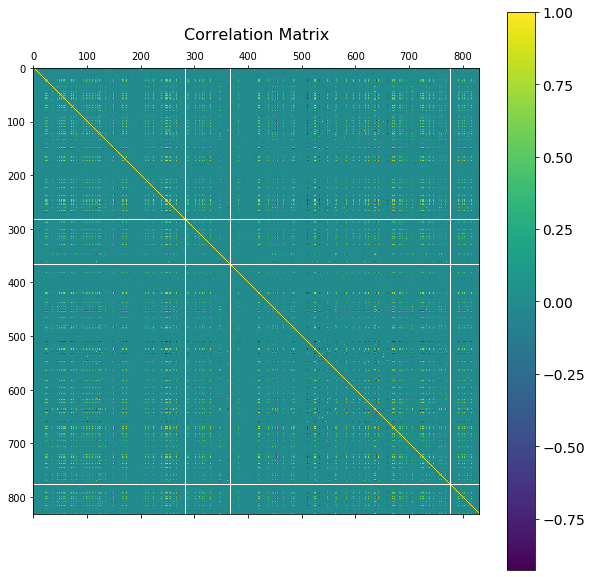

In [43]:
#inspect correlation amongst features
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10, 10))
plt.matshow(x_train.corr(), fignum=f.number)
#plt.xticks(range(x_train.shape[1]), x_train.columns, fontsize=14, rotation=45)
#plt.yticks(range(x_train.shape[1]), x_train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [44]:
#remove highly correlated features

def remove_correlated (dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return(dataset)
    
x_train = remove_correlated(x_train,0.80)
x_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x820,x821,x822,x823,x824,x825,x826,x827,x829,x830
0,2.001809,-0.652740,-1.881312,0.917417,1.454476,-0.388651,1.845923,0.207084,-1.112274,0.275672,...,0.895544,-0.008390,0.821172,-1.107227,0.249939,0.312998,0.903668,0.746658,0.892698,0.925679
1,0.026926,2.406878,-0.211880,1.233120,2.265954,-0.210434,-1.732886,-1.383778,1.477544,0.467879,...,1.336047,0.016619,1.153362,-1.680678,-0.105167,-0.035149,0.099747,0.478875,-0.039934,1.031616
2,-0.500516,2.851133,-0.701401,0.368566,1.686798,1.461403,1.639515,-1.578885,-0.123433,0.429150,...,-0.941872,0.936008,-0.700058,-0.124364,-0.027937,-1.110680,0.759032,-0.886982,0.276651,-0.569888
3,0.555346,-0.460321,2.108910,1.206184,2.218941,-0.070530,0.464995,-0.992993,1.754254,1.231450,...,-1.349537,0.454378,0.233614,1.619696,1.251713,-1.442390,-1.588138,1.421875,-0.715512,0.265215
4,-0.110118,0.526563,-0.286194,0.523945,0.431533,0.225598,-0.843648,1.384996,-0.569341,0.210957,...,-0.740625,1.091439,-0.546425,-0.035512,-1.411038,0.415870,0.141342,-1.259435,2.301585,-0.031837


In [45]:
#removing features with corr > .80 eliminates 56 regressors
#before trying more complex feature selecttion (for example, random forest), we now attemt 
#to fit both a linear and ridge regression model using CV


#standard linear regression
model = LinearRegression().fit(y = y_train, X = x_train)
scores = cross_val_score(estimator = model, X = x_train, y = y_train,
                         scoring = 'r2', cv = 5) 
print(scores)

#try linear regression on original dataset
model_orig = LinearRegression().fit(y = y_train_orig, X = x_train_orig)
scores_orig = cross_val_score(estimator = model, X = x_train_orig, y = y_train_orig,
                         scoring = 'r2', cv = 5) 
print(scores_orig)

#conclusion: eliminating highly correlated features does not work 
#values for r^2 on each fold are lower compared to the values obtained 
#by fitting a simple linear regression model on the initial data

#introduce a regularizer - ridge regression
#we now go back to our original dataset without eliminating correlated features

[-1.851909   -2.67172254 -2.68887218 -1.94833532 -2.1112304 ]
[0.27646374 0.34025975 0.16371133 0.28212967 0.12885713]


In [11]:
################### RUN FROM HERE  #######################

#normalise and clean data

x_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
x_train = x_train.drop('id', axis = 1)
y_train = y_train.drop('id', axis = 1)

x_test = pd.read_csv('X_test.csv')
x_test = x_test.drop('id', axis = 1)

#insert column medians instead of NaN's
x_train = x_train.fillna(x_train.median())
x_test = x_test.fillna(x_test.median())

#rescale data 
scaler = StandardScaler()
x_train_rescaled = scaler.fit_transform(x_train)
x_test_rescaled = scaler.fit_transform(x_test)

x_train = pd.DataFrame(x_train_rescaled, columns = x_train.columns) 
x_test = pd.DataFrame(x_test_rescaled, columns = x_test.columns) 

In [12]:
#feature selection

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(x_train, y_train)
selected_feat = x_train.columns[(sel.get_support())]
x_train = x_train.loc[:,selected_feat]
x_test_with_out = x_test.loc[:,selected_feat]

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [7]:
#outlier detection - data has already been rescaled and features were selected
#method: IsolationForest

to_model_columns = x_train.columns
clf = IsolationForest(n_estimators=500, max_samples='auto', contamination=float(.12), \
                        max_features=0.2, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(x_train[to_model_columns])

pred = clf.predict(x_train[to_model_columns])
x_train['anomaly'] = pred
x_train.drop(x_train.columns[386], axis = 1)
x_train.head()


#outlier_index = list(outliers.index)
#print(x_train['anomaly'].value_counts())

,x0,x2,x3,x6,x10,x11,x13,x17,x18,x19,...,x815,x818,x819,x824,x825,x826,x827,x829,x831,anomaly
0,2.001809,-1.881312,0.917417,1.845923,1.405990,-0.720986,0.799013,0.037724,0.329999,1.374461,...,-0.002819,1.129595,1.480634,0.249939,0.312998,0.903668,0.746658,0.892698,0.149058,1
1,0.026926,-0.211880,1.233120,-1.732886,-1.020680,-0.370262,0.876290,-0.723623,-0.025335,0.185683,...,1.576406,0.007191,-1.313709,-0.105167,-0.035149,0.099747,0.478875,-0.039934,1.217160,1
2,-0.500516,-0.701401,0.368566,1.639515,0.425710,2.008697,-0.999652,-0.871471,-0.208262,-1.868971,...,0.840065,0.686855,-0.114619,-0.027937,-1.110680,0.759032,-0.886982,0.276651,0.107820,-1
3,0.555346,2.108910,1.206184,0.464995,-0.700342,-0.342019,0.939278,-1.671917,0.314703,-1.667762,...,-1.609892,0.465814,-0.112038,1.251713,-1.442390,-1.588138,1.421875,-0.715512,1.292065,1
4,-0.110118,-0.286194,0.523945,-0.843648,-0.870321,1.267598,-0.725764,-0.130591,0.184440,-1.104034,...,-0.193833,0.007191,-1.637788,-1.411038,0.415870,0.141342,-1.259435,2.301585,-2.122182,1


In [8]:
is_not_outlier = x_train['anomaly']==1
#print(is_not_outlier)
x_train_filter = x_train[is_not_outlier]
x_train_filter = x_train_filter.drop(x_train_filter.columns[386], axis = 1)

In [9]:
y_train_filter = y_train[is_not_outlier]

In [10]:
y_train_filter.shape

(1066, 1)

In [32]:
# RANDOM-FOREST -- filtered data -- 10-fold CV
model = RandomForestRegressor(n_estimators = 500).fit(y = y_train_filter, X = x_train_filter)
scores = cross_val_score(estimator = model, X = x_train_filter, y = y_train_filter,
                         scoring = 'r2', cv = 10) 
print("Mean Validation score {}".format(np.mean(scores)))
print("Std Validation score {}".format(np.std(scores)))

Mean Validation score 0.42130503086987164
Std Validation score 0.0931959865853631


In [52]:
# RANDOM-FOREST -- full data (with_out) -- 10-fold CV

model = RandomForestRegressor(n_estimators = 100).fit(y = y_train_with_out, X = x_train_with_out)
scores = cross_val_score(estimator = model, X = x_train_with_out, y = y_train_with_out,
                         scoring = 'r2', cv = 10) 
print("Mean Validation score {}".format(np.mean(scores)))
print("Std Validation score {}".format(np.std(scores)))

Mean Validation score 0.48785057635112317
Std Validation score 0.060187745160902584


In [48]:
predict = model.predict(X = x_test)
index_test = list(range(0, 776))
pd.DataFrame({'id':index_test, 'y':predict}).to_csv('submission.csv', index = False)

In [66]:
## RIDGE REGRESSION --  full data -- 10-fold CV
k = 10

cv_means = []
cv_stds = []
for a in lambdas:
    model = Ridge(alpha = a, fit_intercept = True, normalize=False)
    scores = cross_val_score(estimator = model,
                             X = x_train_with_out,
                             y = y_train_with_out,
                             scoring = 'r2',
                             cv = k)
    cv_means.append(np.mean(scores))
    cv_stds.append(np.std(scores))

<ErrorbarContainer object of 3 artists>

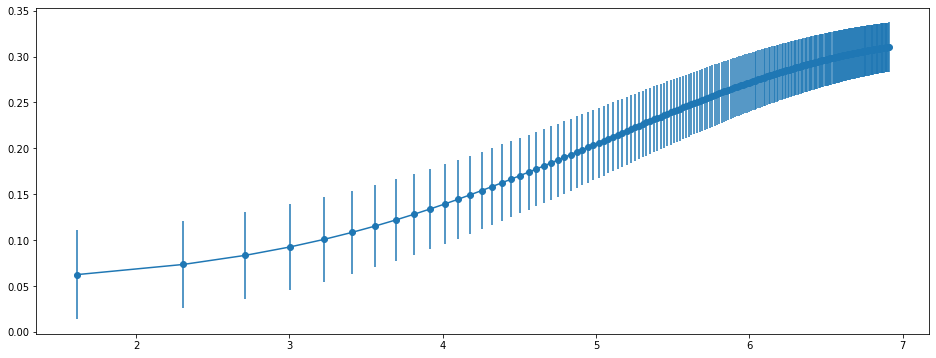

In [67]:
fig, ax = plt.subplots(figsize=(16,6))
ax.errorbar(x = np.log(lambdas), y = cv_means, yerr = np.array(cv_stds)/math.sqrt(10), fmt='-o')

In [72]:
## RIDGE REGRESSION --  filtered data -- 10-fold CV
k = 10


cv_means_filtered = []
cv_stds_filtered = []
for a in lambdas:
    model_filtered = Ridge(alpha = a, fit_intercept = True, normalize=False)
    scores_filtered = cross_val_score(estimator = model_filtered,
                             X = x_train_filter,
                             y = y_train_filter,
                             scoring = 'r2',
                             cv = k)
    cv_means_filtered.append(np.mean(scores_filtered))
    cv_stds_filtered.append(np.std(scores_filtered))

<ErrorbarContainer object of 3 artists>

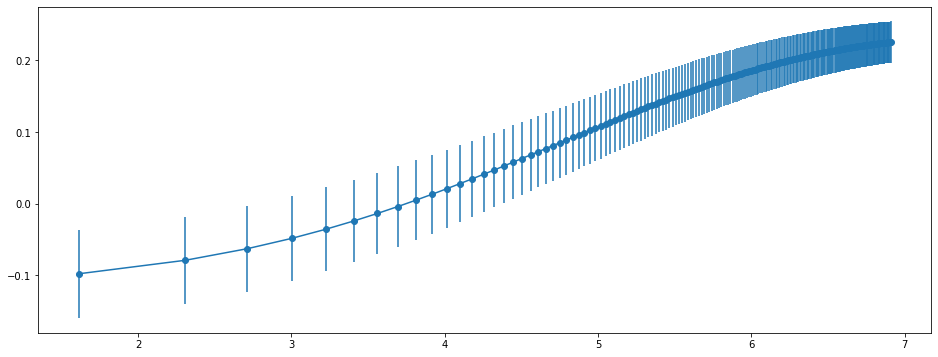

In [88]:
fig, ax = plt.subplots(figsize=(16,6))
ax.errorbar(x = np.log(lambdas), y = cv_means_filtered, yerr = np.array(cv_stds_filtered)/math.sqrt(10), fmt='-o')

In [81]:
print(max(cv_means), max(cv_means_filtered))
#as previously seen, fitting model on entire dataset is better
#possible (probable as well) casuse: both models tested so far (RR, Ridge) are sufficiently robust to outliers

0.31028204199819975 0.22543894931122538


In [13]:
### attempt to fit a SupportVector regression model 
model = SVR(kernel='rbf')


scores = cross_val_score(estimator = model, X = x_train_with_out, y = y_train_with_out,
                         scoring = 'r2', cv = 10) 
print("Mean Validation score {}".format(np.mean(scores)))
print("Std Validation score {}".format(np.std(scores)))

Mean Validation score 0.27306197245306746
Std Validation score 0.05260602561091761


In [28]:
####refining data preprocessing stage --- implementing t-sne for dimension reduction

x_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
x_train = x_train.drop('id', axis = 1)
y_train = y_train.drop('id', axis = 1)

x_test = pd.read_csv('X_test.csv')
x_test = x_test.drop('id', axis = 1)

#insert column medians instead of NaN's
x_train = x_train.fillna(x_train.median())
x_test = x_test.fillna(x_test.median())

#demeaned dataset
#x_train_demeaned = x_train - x_train.mean()

#rescale data 
scaler = StandardScaler()
x_train_rescaled = scaler.fit_transform(x_train)
x_test_rescaled = scaler.fit_transform(x_test)

x_train = pd.DataFrame(x_train_rescaled, columns = x_train.columns) 
x_test = pd.DataFrame(x_test_rescaled, columns = x_test.columns)

In [29]:
x_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,2.001809,-0.652740,-1.881312,0.917417,1.454476,-0.388651,1.845923,0.207084,-1.112274,0.275672,...,0.821172,-1.107227,0.249939,0.312998,0.903668,0.746658,-0.945093,0.892698,0.925679,0.149058
1,0.026926,2.406878,-0.211880,1.233120,2.265954,-0.210434,-1.732886,-1.383778,1.477544,0.467879,...,1.153362,-1.680678,-0.105167,-0.035149,0.099747,0.478875,2.612160,-0.039934,1.031616,1.217160
2,-0.500516,2.851133,-0.701401,0.368566,1.686798,1.461403,1.639515,-1.578885,-0.123433,0.429150,...,-0.700058,-0.124364,-0.027937,-1.110680,0.759032,-0.886982,0.648200,0.276651,-0.569888,0.107820
3,0.555346,-0.460321,2.108910,1.206184,2.218941,-0.070530,0.464995,-0.992993,1.754254,1.231450,...,0.233614,1.619696,1.251713,-1.442390,-1.588138,1.421875,-0.207605,-0.715512,0.265215,1.292065
4,-0.110118,0.526563,-0.286194,0.523945,0.431533,0.225598,-0.843648,1.384996,-0.569341,0.210957,...,-0.546425,-0.035512,-1.411038,0.415870,0.141342,-1.259435,-1.072406,2.301585,-0.031837,-2.122182


In [ ]:
# k-fold cross validation evaluation of xgboost model
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# CV model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=10, random_state=7)
print('Here')
results = cross_val_score(model, x_train_pca, y_train, cv=kfold, scoring = 'r2')
print("R2: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Here


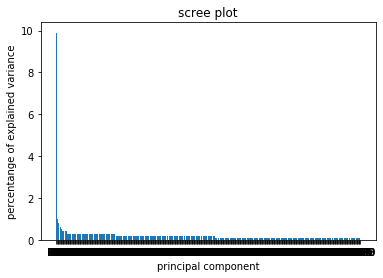

0.9000056927257419


In [176]:
pca = PCA(n_components=430)
x_train_pca = pca.fit_transform(x_train)
x_pca = pd.DataFrame(data = x_train_pca)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('percentange of explained variance')
plt.xlabel('principal component')
plt.title('scree plot')
plt.show()

print(sum(pca.explained_variance_ratio_))

In [177]:
x_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,420,421,422,423,424,425,426,427,428,429
0,-5.765271,-3.682313,0.857241,-1.831988,-2.908832,1.397229,0.773894,-1.022839,-2.470053,-1.024280,...,0.180687,1.435508,-0.511165,-0.497494,0.388059,0.779450,-0.161246,0.314560,0.964507,0.364871
1,19.601436,1.187761,-1.230873,-4.489696,1.390418,4.787640,-0.943502,-0.561817,1.720153,1.591280,...,-0.479132,0.312535,0.833898,-0.149383,-0.021958,0.157952,0.548600,-0.655630,0.005986,-0.748928
2,11.652532,7.163971,-7.673858,1.358457,-0.807556,-3.090912,1.201129,1.921433,3.974950,-5.040273,...,-0.854626,-0.554451,-0.047631,-0.680556,-0.288814,-0.841151,-0.141271,-0.120267,-0.073426,1.426932
3,0.925125,-7.725411,-4.382778,0.909811,-1.741412,1.625499,-0.462799,-0.169767,-0.923537,-1.760037,...,-0.370516,-0.113107,-0.636731,0.015749,0.234911,0.779169,0.878632,-0.872724,0.349853,-0.099655
4,-2.289300,6.937420,-6.087772,0.368845,-1.846973,3.660551,0.859414,3.317418,0.174184,-2.591285,...,0.354401,1.371604,-1.692980,0.060381,0.606350,0.665250,0.079439,-1.229344,-1.033755,0.126470


In [178]:
model = RandomForestRegressor(n_estimators = 100).fit(y = y_train, X = x_train_pca)
scores = cross_val_score(estimator = model, X = x_train_pca, y = y_train,
                         scoring = 'r2', cv = 10) 
print("Mean Validation score {}".format(np.mean(scores)))
print("Std Validation score {}".format(np.std(scores)))

Mean Validation score 0.3341004049336555
Std Validation score 0.060195009533367254


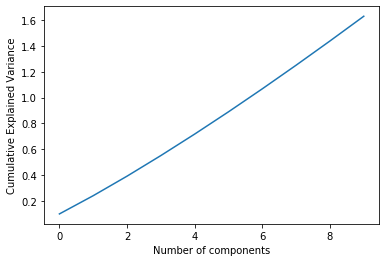

In [159]:
pca = PCA(n_components=10).fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_.cumsum()))
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance');

In [130]:
# Highly ad hoc way of removing outliers based on PCA plot above
## USING ANDREAS' LABELLING

outliers = (xpca['PC1'] <= 22) & (xpca['PC1'] >= -18) & (xpca['PC2'] <= 12) & (xpca['PC2'] >= -13)
print(np.count_nonzero(outliers))
x_train_without_outliers = x_train[outliers]
ytrain_without_outliers = y_train[outliers]
#below, use x_train_without_outliers, y_train_without_outliers

1139


(1139, 832)

In [ ]:
#try regession on isomap compressed dataset 

# RANDOM-FOREST -- feature selection + isomap compressed dataset -- 10-fold CV

model = RandomForestRegressor(n_estimators = 100).fit(y = y_train_with_out, X = manifold_2D)
scores = cross_val_score(estimator = model, X = manifold_2D, y = y_train_with_out,
                         scoring = 'r2', cv = 10) 
print("Mean Validation score {}".format(np.mean(scores)))
print("Std Validation score {}".format(np.std(scores)))

In [ ]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [65]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [73]:
X_train = preprocessing.scale(X_train)

X_test = preprocessing.scale(X_test)

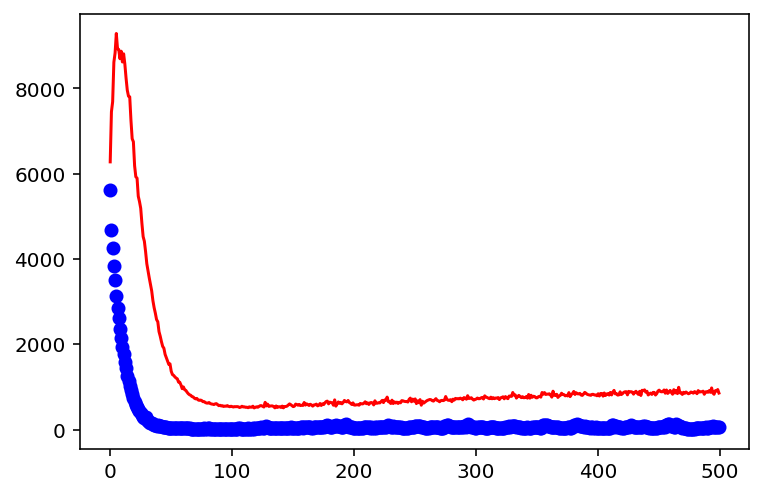

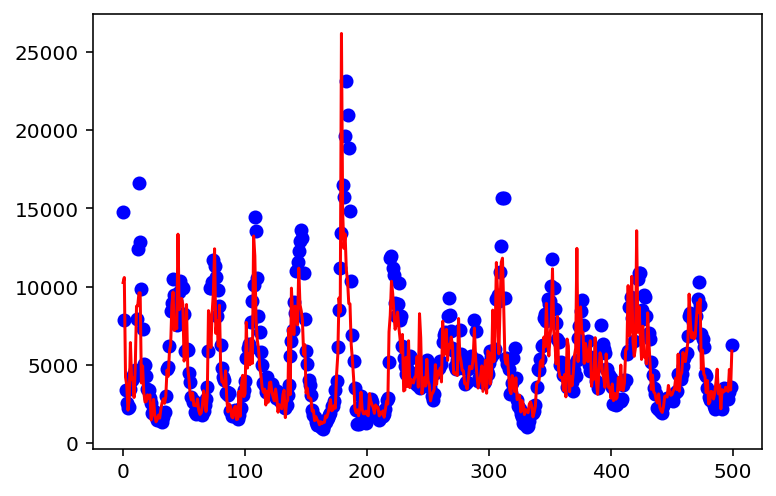

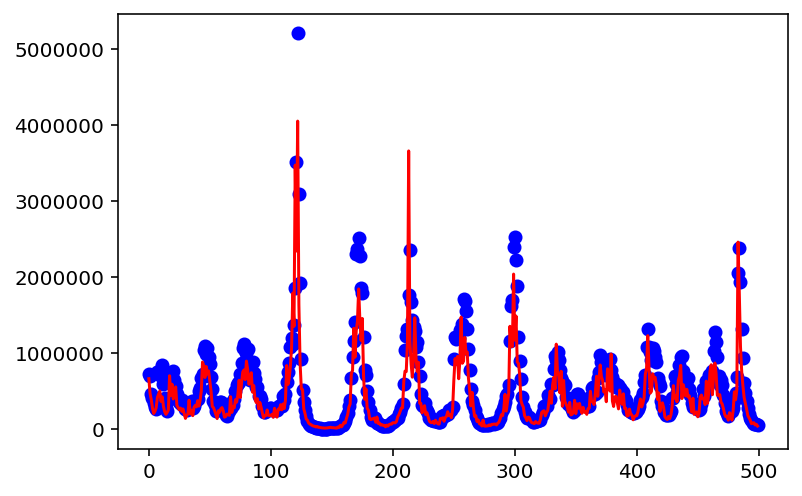

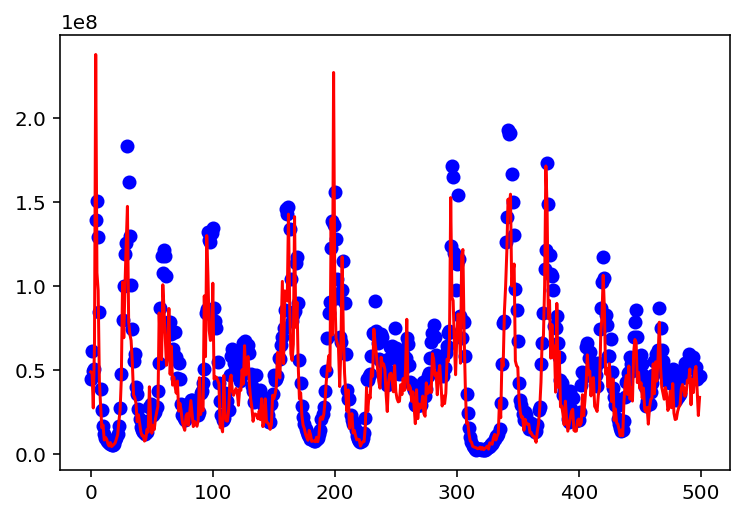

In [74]:
LR = [0.1,1,10,100]

for i in LR:
    #Defines linear regression model and its structure
    model = Sequential()
    model.add(Dense(1, input_shape=(832,)))
    
    #Compiles model
    model.compile(Adam(lr=i), 'mean_squared_error')
    
    #Fits model
    history = model.fit(X_train, y_train, epochs = 500, validation_split = 0.1,verbose = 0)
    history_dict=history.history
    
    #Plots model's training cost/loss and model's validation split cost/loss
    loss_values = history_dict['loss']
    val_loss_values=history_dict['val_loss']
    plt.figure()
    plt.plot(loss_values,'bo',label='training loss')
    plt.plot(val_loss_values,'r',label='val training loss')

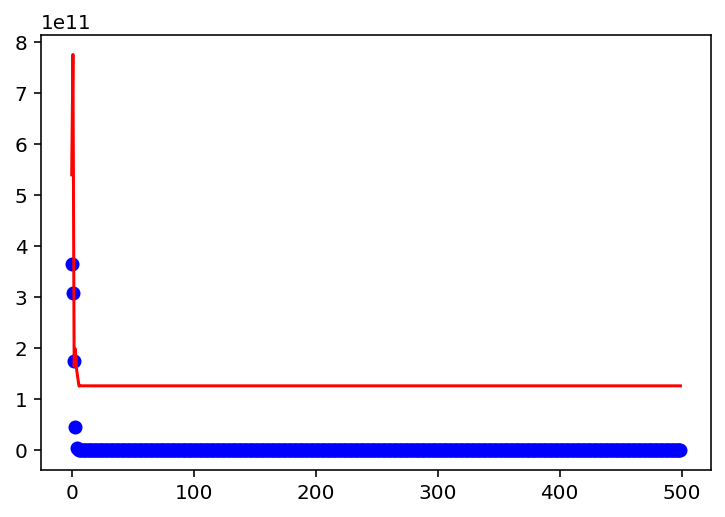

In [75]:
model = Sequential()
model.add(Dense(1, input_shape=(832,), activation = 'relu'))
model.compile(Adam(lr=10000), 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = 500, validation_split = 0.1,verbose = 0)

history_dict=history.history
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='training loss val')

In [76]:
# Runs model (the one with the activation function, although this doesn't really matter as they perform the same) 
# with its current weights on the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

The R2 score on the Train set is:	-123582221.276
The R2 score on the Test set is:	-386169952.186


In [ ]:
## attempt with neural network

In [143]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [146]:
model = Sequential()
model.add(Dense(64, input_shape=(453,), kernel_initializer='normal', activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 64)                29056     
_________________________________________________________________
dense_112 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_113 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_114 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 9         
Total params: 31,809
Trainable params: 31,809
Non-trainable params: 0
_________________________________________________________________


In [147]:
model.compile(Adam(lr=0.01), 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = 3000, validation_split = 0.2,verbose = 0)

dict_keys(['val_loss', 'loss'])


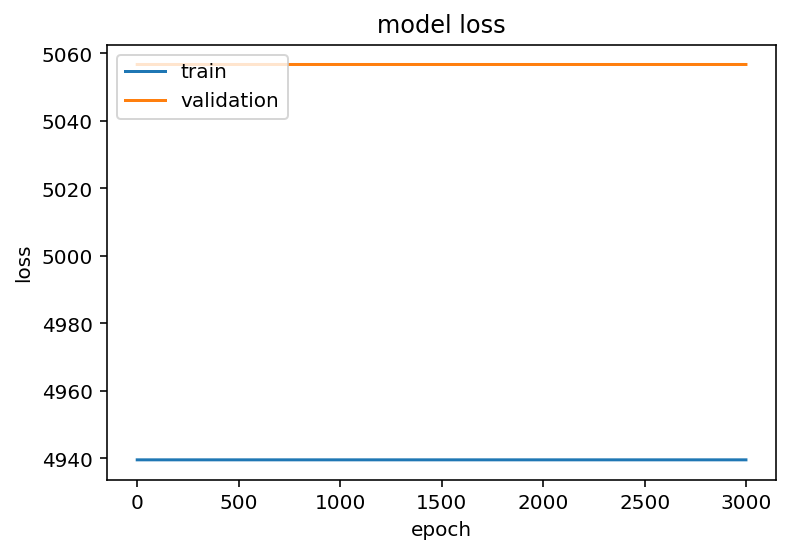

In [148]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [149]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

The R2 score on the Train set is:	-48.017
The R2 score on the Test set is:	-52.198


In [2]:
#kernel pca for reduction then random forest regression

x_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
x_train = x_train.drop('id', axis = 1)
y_train = y_train.drop('id', axis = 1)

x_test = pd.read_csv('X_test.csv')
x_test =x_test.drop('id', axis = 1)

#insert column medians instead of NaN's
x_train = x_train.fillna(x_train.median())

#rescale data 
scaler = StandardScaler()
x_train_rescaled = scaler.fit_transform(x_train)


x_train = pd.DataFrame(x_train_rescaled, columns = x_train.columns) 
x_train.head()
#note: x_train is now the rescaled original data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,2.001809,-0.652740,-1.881312,0.917417,1.454476,-0.388651,1.845923,0.207084,-1.112274,0.275672,...,0.821172,-1.107227,0.249939,0.312998,0.903668,0.746658,-0.945093,0.892698,0.925679,0.149058
1,0.026926,2.406878,-0.211880,1.233120,2.265954,-0.210434,-1.732886,-1.383778,1.477544,0.467879,...,1.153362,-1.680678,-0.105167,-0.035149,0.099747,0.478875,2.612160,-0.039934,1.031616,1.217160
2,-0.500516,2.851133,-0.701401,0.368566,1.686798,1.461403,1.639515,-1.578885,-0.123433,0.429150,...,-0.700058,-0.124364,-0.027937,-1.110680,0.759032,-0.886982,0.648200,0.276651,-0.569888,0.107820
3,0.555346,-0.460321,2.108910,1.206184,2.218941,-0.070530,0.464995,-0.992993,1.754254,1.231450,...,0.233614,1.619696,1.251713,-1.442390,-1.588138,1.421875,-0.207605,-0.715512,0.265215,1.292065
4,-0.110118,0.526563,-0.286194,0.523945,0.431533,0.225598,-0.843648,1.384996,-0.569341,0.210957,...,-0.546425,-0.035512,-1.411038,0.415870,0.141342,-1.259435,-1.072406,2.301585,-0.031837,-2.122182


In [5]:
#feature selection

#sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
#sel.fit(x_train, y_train)
#selected_feat = x_train.columns[(sel.get_support())]
#x_train = x_train.loc[:,selected_feat]
#x_test = x_test.loc[:,selected_feat]

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'lbfgs')
rfe = RFE(model, 200)
fit = rfe.fit(x_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)


Num Features: 200
Selected Features: [False False  True False False  True False False False False False False
 False False False False False False  True False False  True False False
  True  True False  True False False False False False False  True False
 False False False  True False False False False False False False False
 False False False False False False False False False False  True False
  True False False  True False False False  True False False  True False
 False  True  True False False False False  True False False False  True
 False False False  True False False False  True  True False  True False
 False False False False False False False False  True False False  True
 False False False False False  True False False False False  True False
  True False False False  True False False False False False False False
 False  True  True False False False False  True False False False False
 False False False False False  True False  True False False False False
 False False F

In [6]:
x_train_sel = x_train.loc[:,fit.support_]
x_test_sel = x_test.loc[:,fit.support_]

In [13]:
#dimension reduction

from sklearn.decomposition import KernelPCA
transformer = KernelPCA(n_components = 100, kernel='rbf')
x_train_red = transformer.fit_transform(x_train_sel)

In [14]:
# RANDOM-FOREST -- full data kernel pca -- 10-fold CV

model = RandomForestRegressor(n_estimators = 100).fit(y = y_train, X = x_train_red)
scores = cross_val_score(estimator = model, X = x_train_red, y = y_train,
                         scoring = 'r2', cv = 10) 
print("Mean Validation score {}".format(np.mean(scores)))
print("Std Validation score {}".format(np.std(scores)))

Mean Validation score 0.3893290140517876
Std Validation score 0.07740138558300422
